In [1]:
import numpy as np
import numpy
import pandas
import scanpy
import scanpy as sc
import anndata
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import math

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

/home/ubuntu/.local/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4 anndata==0.6.19 numpy==1.16.3 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Simulating a single cell experiment

1. `cell_no` – number of rows/cells.
2. `gene_no` – number of columns/genes.
3. We simulate count matrix by assuming it follows a hierarchical process: `poisson(lognormal(0, 0.1))`. This can be argued to make sense: poisson simulates the bead and lognormal simulates the true expression of a gene. Better models are possible (e.g. assuming different genes have different expression rates, etc.).
4. We simulate velocity to follow a normal distribution with mu=0 and sigma=1.

In [2]:
def create_cell(gene_no, function, constants):
    result = []
    for i in range(gene_no):
        result.append(function(*constants))
    return numpy.array(result).reshape(1, -1)

In [3]:
def create_experiment(cell_no, gene_no, function, constants):
    experiment = numpy.zeros(shape=(cell_no, gene_no))
    for i in range(cell_no):
        experiment[i, :] = create_cell(gene_no, function, constants)
    return experiment

In [4]:
spliced = create_experiment(10, 5, lambda mu, sigma: numpy.random.poisson(numpy.random.lognormal(mu, sigma)), [0, 0.1])

In [5]:
spliced

array([[0., 2., 3., 0., 1.],
       [1., 0., 0., 1., 1.],
       [0., 2., 0., 1., 1.],
       [2., 1., 1., 1., 0.],
       [0., 1., 1., 4., 1.],
       [2., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 2.],
       [3., 2., 1., 0., 0.],
       [2., 0., 0., 1., 1.]])

In [6]:
velocity = create_experiment(10, 5, numpy.random.normal, [0, 1])

In [7]:
velocity

array([[ 0.43843979, -1.35895725, -0.11827132, -0.44059959,  1.59535723],
       [-1.01135683, -0.04457877,  0.19627953,  1.32951122, -0.46578626],
       [-1.37017384,  0.25156638, -0.06789413, -1.61574726, -0.54339377],
       [ 0.98589546,  1.21219454,  2.09262308, -0.91876721, -0.37654932],
       [-1.2821195 ,  1.5916665 , -1.38607393,  1.00845075,  2.09355035],
       [ 0.94466136, -0.98188529, -2.29250733,  1.21881376, -0.74542735],
       [ 1.37055712,  2.75666436, -2.1390652 , -1.4297868 , -0.90555974],
       [ 0.10939897, -0.59282805, -0.78427135, -0.21911309, -0.85239557],
       [ 0.49035786,  0.03525871, -2.55996731, -1.20420914, -2.16526605],
       [-0.51633584, -1.33324843,  1.16666591,  0.3966788 ,  0.81100114]])

In [8]:
velocity.shape

(10, 5)

In [9]:
assert velocity.shape == spliced.shape

That's how we can choose an example cell's velocity

In [10]:
example_velocity = velocity[-3, :]
example_velocity

array([ 0.10939897, -0.59282805, -0.78427135, -0.21911309, -0.85239557])

And an example cell

In [11]:
example_cell = spliced[-3, :]
example_cell

array([0., 0., 1., 1., 2.])

# The next bit is some rather easy linear algebra

We're just going to take a projection of velocity onto the position vector, and measure that. This will allow us to define and measure differentiation rate.

![velocity projection](https://trello-attachments.s3.amazonaws.com/5a982c9ba3afcf0a82b5b26c/5c84e116d5a3ed167f8ac28a/b4e329c442b2e809f7270ebf8ad8e07f/IMG_20190310_100347422.jpg)

# The cell above has made all the right life choices! See, her career narrative is showing a "clear, fairly linear development" along her chosen path. Before long, she'll be in a position of leadership and influence, recognised among many cells! We should all aspire to be like this cell!

In [12]:
def project(velocity, position):
    projection = numpy.dot(velocity, position)/numpy.linalg.norm(position)
    projection_vector = position/numpy.linalg.norm(position)*projection
    return projection, projection_vector

Exercise. Plot the following vectors and their respective projections on a sheet of paper

In [13]:
project([0, 1], [1, 0])

(0.0, array([0., 0.]))

In [14]:
project([0.1, 1], [1, 0])

(0.1, array([0.1, 0. ]))

In [15]:
project([0, 1], [1, 0.1])

(0.09950371902099893, array([0.0990099 , 0.00990099]))

In [16]:
project([1, 1], [2, 2])

(1.414213562373095, array([1., 1.]))

In [17]:
project([-1, -1], [2, 2])

(-1.414213562373095, array([-1., -1.]))

And that's how we can compute the projection for a single cell

In [18]:
project(velocity[-3, :], spliced[-3, :])

(-1.1056080505978407,
 array([-0.        , -0.        , -0.4513626 , -0.4513626 , -0.90272519]))

We can now compute the ratio of average neutral velocity to average differentiation velocity. Let's call that "differentiation factor"

In [19]:
def compute_differentiation(spliced, velocity):
    differentiation_speed = []
    neutral_speed = []
    for cell_no in range(velocity.shape[0]):
        p = spliced[cell_no, :]
        v = velocity[cell_no, :]
        speed_away, velocity_away = project(v, p)
        neutral = numpy.linalg.norm(v - velocity_away)
        if not math.isnan(speed_away) and not math.isnan(neutral):
            differentiation_speed.append(speed_away)
            neutral_speed.append(neutral)
    differentiation_factor = sum(differentiation_speed)/sum(neutral_speed)
    return differentiation_factor, neutral_speed, differentiation_speed

In [20]:
compute_differentiation(spliced, velocity)

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(0.07796354345657472,
 [2.153223908833271,
  1.7437452308600279,
  2.0962173184800825,
  2.2568630169378388,
  3.063903844098247,
  2.867550088853831,
  0.7285014566956749,
  3.5860208406943466,
  2.053103916616616],
 [-0.3948440681547448,
  -0.08523529702183824,
  -0.6760625393581825,
  1.64710920218102,
  1.4528774400040938,
  0.9645719633991704,
  -1.1056080505978407,
  -0.2721725151702411,
  0.07144682500359927])

# Centralising the experiment and computing the differentiation factor

Before we can use this method we have to determine the correct origin. I suggest just using the most average cell as the origin. This can be achieved by recentrilising the entire experiment to put the hypothetical "average cell" in the middle. We don't have to touch the velocity vectors, because the transformation doesn't affect them.

In [21]:
def centralise_experiment(spliced):
    average_cell = spliced.sum(0)/spliced.shape[0]
    for i in range(spliced.shape[0]):
        spliced[i, :] -= average_cell 

In [22]:
spliced

array([[0., 2., 3., 0., 1.],
       [1., 0., 0., 1., 1.],
       [0., 2., 0., 1., 1.],
       [2., 1., 1., 1., 0.],
       [0., 1., 1., 4., 1.],
       [2., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 2.],
       [3., 2., 1., 0., 0.],
       [2., 0., 0., 1., 1.]])

In [23]:
centralise_experiment(spliced)

In [24]:
spliced

array([[-1. ,  1.2,  2.3, -1. ,  0.2],
       [ 0. , -0.8, -0.7,  0. ,  0.2],
       [-1. ,  1.2, -0.7,  0. ,  0.2],
       [ 1. ,  0.2,  0.3,  0. , -0.8],
       [-1. ,  0.2,  0.3,  3. ,  0.2],
       [ 1. , -0.8, -0.7,  0. ,  0.2],
       [-1. , -0.8, -0.7, -1. , -0.8],
       [-1. , -0.8,  0.3,  0. ,  1.2],
       [ 2. ,  1.2,  0.3, -1. , -0.8],
       [ 1. , -0.8, -0.7,  0. ,  0.2]])

# Now we can compute the differentiation factor

In [25]:
differentiation_factor, neutral_velocity, differentiation_velocity = compute_differentiation(spliced, velocity)

In [26]:
differentiation_velocity

[-0.534048611654253,
 -0.1801757858961076,
 0.9347393600491668,
 1.621571638917,
 1.4514360179567987,
 2.1626886035524295,
 0.03898317117747254,
 -0.5017231230811376,
 1.1918718175594203,
 -0.07073760476520592]

In [27]:
differentiation_factor

0.25378333079442583

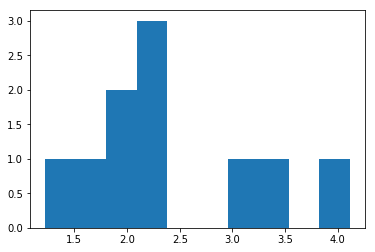

In [28]:
_ = plt.hist(neutral_velocity)

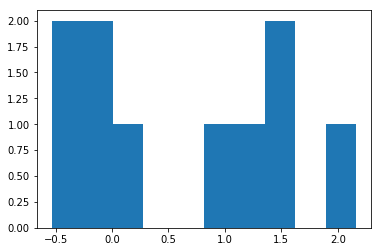

In [29]:
_ = plt.hist(differentiation_velocity)

# Load real data

In [30]:
import os

BATCH_LABELS = ("S1", "S2")
batches = {}

for batch in BATCH_LABELS:
    filename = "tgfb1-5-" + batch + ".h5ad"
    filename = os.path.join("write", filename)
    batches[batch] = anndata.read(filename)

batches

{'S1': AnnData object with n_obs × n_vars = 5019 × 7176 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'louvain', 'cVSMC signature'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
     uns: 'batch_colors', 'genes_before_highly_variable', 'genes_original', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'phase_colors', 'velocity_graph', 'velocity_graph_neg'
     obsm: 'X_pca', 'X_umap', 'velocity_umap'
     varm: 'PCs'
     layers: 'Ms', 'Mu', 'ambiguous', 'spliced', 'unspliced', 'variance_velocity', 'velocity',
 'S2': AnnData object with n_obs × n_vars = 7047 × 7176 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'louvain', 'cVSMC signature'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
     uns: 'batch

In [31]:
treated = batches["S2"]
nontreated = batches["S1"]

In [32]:
nontreated.layers["velocity"]

array([[-0.11669185, -0.04802166, -0.07153951, ...,  0.        ,
         0.53530145,  0.1010994 ],
       [-0.08634764, -0.00076031, -0.01795642, ...,  0.        ,
         0.2760117 ,  0.1790248 ],
       [-0.11763915, -0.01089987,  0.2144634 , ...,  0.        ,
         0.08790916, -0.00258453],
       ...,
       [-0.08517344, -0.03696687,  0.09121668, ...,  0.        ,
         0.09474653,  0.3227505 ],
       [-0.03922656,  0.        ,  0.0711737 , ...,  0.        ,
         0.27183205,  0.10610638],
       [-0.046618  ,  0.03568673,  0.03314865, ...,  0.        ,
         0.63713473,  0.04866816]], dtype=float32)

In [33]:
nontreated.X

array([[-0.6004064 , -0.21971689, -0.4200029 , ..., -0.13642852,
        -0.26846844, -0.2538597 ],
       [-0.6502322 , -0.28391638, -0.46995193, ..., -0.13294181,
        -0.36231437, -0.3127136 ],
       [ 2.5737274 , -0.2233157 , -0.4137076 , ..., -0.10701179,
        -0.27550325, -0.24783038],
       ...,
       [-0.58626944, -0.19807717, -0.3667681 , ..., -0.12046557,
        -0.22420949, -0.20947437],
       [ 0.315436  , -0.26154032, -0.39149612, ..., -0.19005205,
        -0.29169983, -0.26187205],
       [-0.55516213, -0.16892871,  1.288223  , ..., -0.16973138,
        -0.21429522, -0.24765119]], dtype=float32)

In [34]:
control_df, control_neutral_velocity, control_differentiation_velocity = compute_differentiation(nontreated.X, nontreated.layers["velocity"])

In [35]:
control_differentiation_velocity

[-1.067467,
 -0.2089748,
 -1.5438563,
 -0.91264266,
 -1.5572411,
 -0.62484527,
 -0.3657331,
 -0.8563156,
 -1.2276795,
 -1.3563625,
 -0.8722153,
 -0.8928432,
 -1.268301,
 0.48562312,
 -1.656003,
 -0.6768585,
 -0.9563226,
 -1.7006742,
 -0.45581913,
 -1.5841268,
 -1.8158258,
 0.11109917,
 -0.637871,
 -0.6323629,
 -1.2443688,
 -1.1784712,
 -0.25385827,
 -0.42944357,
 -1.032132,
 -1.1171739,
 -1.5637652,
 -1.6838609,
 -1.5108528,
 -0.20528363,
 -0.6379163,
 -1.2802268,
 -0.58491606,
 -1.0110043,
 -2.2828853,
 -1.5732375,
 -1.2243403,
 -0.2573865,
 -1.4921587,
 -0.7619268,
 -0.49123707,
 -0.32273445,
 -0.9838162,
 -1.199426,
 -1.2337729,
 1.4434373,
 -1.1053766,
 -1.2613508,
 -1.3042293,
 -0.66300213,
 -1.0054568,
 -0.23736268,
 0.2123146,
 -0.6417677,
 -0.7933647,
 -0.55922085,
 -0.105203524,
 0.20589115,
 -1.1043041,
 -1.5299027,
 -1.887018,
 -1.0362533,
 -1.0888513,
 -1.6731272,
 0.101713754,
 0.21996857,
 -0.9398176,
 0.049240693,
 -0.9507315,
 -0.7420349,
 -0.8944619,
 -1.0792218,
 -0.4

In [36]:
treated_df, treated_neutral_velocity, treated_differentiation_velocity = compute_differentiation(treated.X, treated.layers["velocity"])

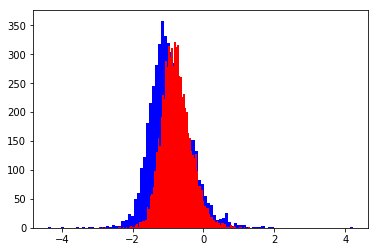

In [37]:
f = plt.figure()
_ = plt.hist(control_differentiation_velocity, bins=100, color="blue")
_ = plt.hist(treated_differentiation_velocity, bins=100, color="red")

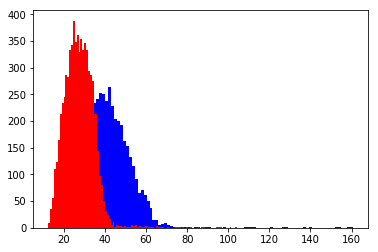

In [38]:
f = plt.figure()
_ = plt.hist(control_neutral_velocity, bins=100, color="blue")
_ = plt.hist(treated_neutral_velocity, bins=100, color="red")

In [39]:
control_df

-0.023245169434308398

In [40]:
treated_df

-0.02778002686757496

# Velocity per louvain cluster

In [41]:
treated.layers["velocity"].shape

(7047, 7176)

In [42]:
louvain_indices = dict()
for i, louvain in enumerate(treated.obs["louvain"]):
    l = louvain_indices.get(louvain, [])
    l.append(i)
    louvain_indices[louvain] = l

In [43]:
def lengths_for_cluster(k):
    cluster_vel = treated.layers["velocity"][louvain_indices[k]]
    return [numpy.linalg.norm(i) for i in cluster_vel]

In [44]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [45]:
angle_between([1, -1], [1, 1])

1.5707963267948966

In [46]:
def angles_for_cluster(k):
    cluster_vel = treated.layers["velocity"][louvain_indices[k]]
    result = []
    for _ in range(1000):
        i = cluster_vel[random.randint(0, len(cluster_vel) - 1)]
        j = cluster_vel[random.randint(0, len(cluster_vel) - 1)]
        result.append(angle_between(i, j) * 180/math.pi)
    return result

In [47]:
length_distribution = [lengths_for_cluster(k) for k in sorted(louvain_indices.keys())]

In [48]:
import random

In [49]:
angle_distribution = [angles_for_cluster(k) for k in sorted(louvain_indices.keys())]

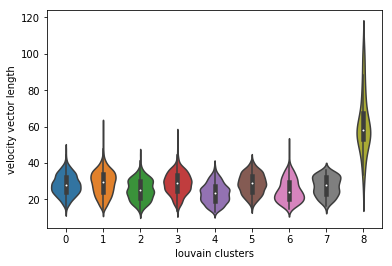

In [50]:
ax = seaborn.violinplot(data=length_distribution)
ax.set(xlabel='louvain clusters', ylabel='velocity vector length')
plt.show()

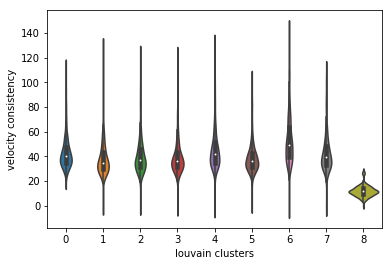

In [51]:
ax = seaborn.violinplot(data=angle_distribution)
ax.set(xlabel='louvain clusters', ylabel='velocity consistency')
plt.show()

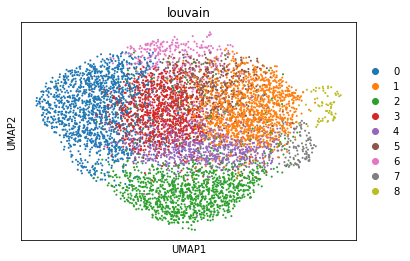

In [52]:
sc.pl.umap(treated, color=["louvain"])

<Figure size 432x288 with 0 Axes>

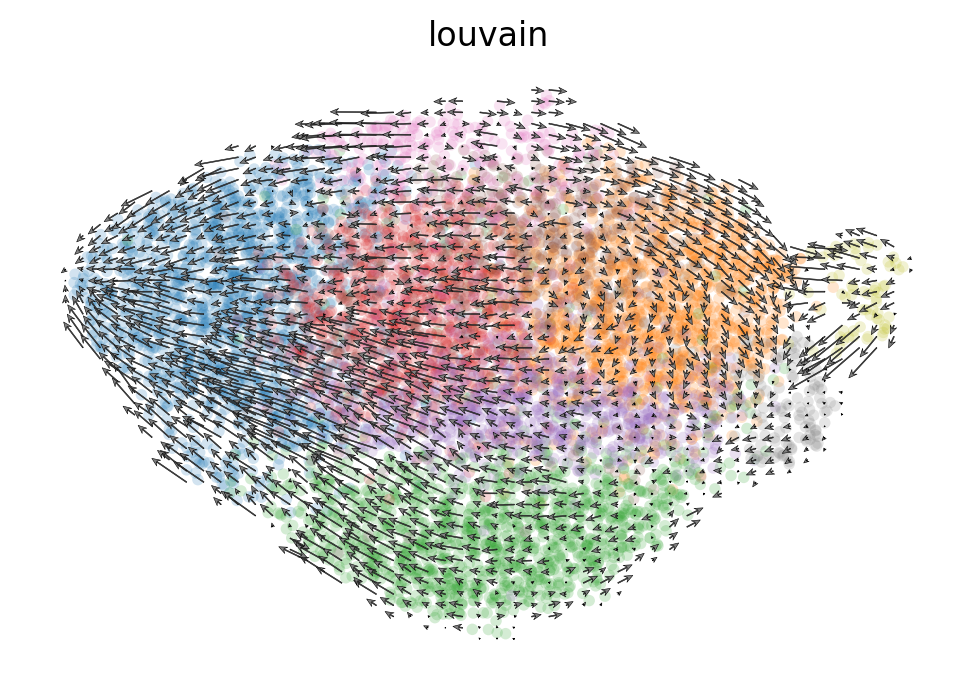

In [53]:
scv.pl.velocity_embedding_grid(treated, basis='umap', arrow_length=4, arrow_size=1.5, dpi=200)

In [54]:
import random

In [55]:
random.randint(0, 1)

1